In [1]:
import tensorflow as tf
from keras import layers, models, applications, callbacks
import matplotlib.pyplot as plt
import os
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
batch_size = 50
img_height = 300
img_width = 300
dataset_path = "RetinalOCT_Dataset"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "test")
epochs = 50

In [4]:
if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    raise FileNotFoundError(f"Train or Validation dataset path not found: {os.path.abspath(dataset_path)}")


In [5]:
# Load training dataset
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=(img_height, img_width), batch_size=batch_size
)

# Load validation dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=(img_height, img_width), batch_size=batch_size
)

Found 16888 files belonging to 8 classes.
Found 2800 files belonging to 8 classes.


In [6]:
# Get class names
class_names = training_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")

Class names: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']


In [7]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2)
])


In [8]:
# Apply data augmentation to training dataset
training_ds = training_ds.map(lambda x, y: (data_augmentation(x), y))


In [11]:
# Load pre-trained ResNet50 model (without top layers)
base_model = applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)
)
base_model.trainable = False  # Freeze base layers initially


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 63s 1us/step


In [12]:
# Add custom CNN layers on top of ResNet
inputs = layers.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

In [13]:
# Create model
retinal_model = models.Model(inputs, outputs)
# Compile model
retinal_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [14]:
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [15]:
# Train only the custom CNN layers first
history = retinal_model.fit(
    training_ds, validation_data=validation_ds, epochs=5, callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 2593s 8s/step - accuracy: 0.5294 - loss: 1.3116 - val_accuracy: 0.7293 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 2/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 2435s 7s/step - accuracy: 0.7273 - loss: 0.6842 - val_accuracy: 0.7714 - val_loss: 0.5669 - learning_rate: 0.0010
Epoch 3/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 2419s 7s/step - accuracy: 0.7500 - loss: 0.6201 - val_accuracy: 0.7886 - val_loss: 0.5224 - learning_rate: 0.0010
Epoch 4/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 2349s 7s/step - accuracy: 0.7647 - loss: 0.5829 - val_accuracy: 0.7639 - val_loss: 0.5700 - learning_rate: 0.0010
Epoch 5/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 2355s 7s/step - accuracy: 0.7686 - loss: 0.5693 - val_accuracy: 0.7550 - val_loss: 0.5867 - learning_rate: 0.0010


In [16]:
# Fine-tune ResNet layers (Unfreeze top layers)
base_model.trainable = True
for layer in base_model.layers[:140]:  # Freeze first 140 layers, fine-tune last ones
    layer.trainable = False

# Recompile model with lower learning rate for fine-tuning
retinal_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
# Train again with fine-tuned ResNet layers
history_finetune = retinal_model.fit(
    training_ds, validation_data=validation_ds, epochs=epochs, callbacks=[lr_scheduler, early_stopping]
)

# Evaluate model
val_loss, val_acc = retinal_model.evaluate(validation_ds)
print(f"Test Accuracy: {val_acc:.4f}")

# Save model
retinal_model.save("retinal_resnet50_finetuned.h5")


Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 3224s 9s/step - accuracy: 0.8166 - loss: 0.4823 - val_accuracy: 0.8979 - val_loss: 0.2729 - learning_rate: 1.0000e-04
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 3208s 9s/step - accuracy: 0.9038 - loss: 0.2647 - val_accuracy: 0.8611 - val_loss: 0.3785 - learning_rate: 1.0000e-04
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 3252s 10s/step - accuracy: 0.9199 - loss: 0.2170 - val_accuracy: 0.8964 - val_loss: 0.3154 - learning_rate: 1.0000e-04
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 4097s 12s/step - accuracy: 0.9330 - loss: 0.1964 - val_accuracy: 0.9232 - val_loss: 0.2175 - learning_rate: 1.0000e-04
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 4340s 13s/step - accuracy: 0.9385 - loss: 0.1734 - val_accuracy: 0.9264 - val_loss: 0.2170 - learning_rate: 1.0000e-04
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 4357s 13s/step - accuracy: 0.9398 - loss: 0.1686 - val_accuracy: 0.8957 - val_loss: 0.3086 - learning_rate: 1.0000e-04
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 4204s 12

Test Accuracy: 0.9593


In [20]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


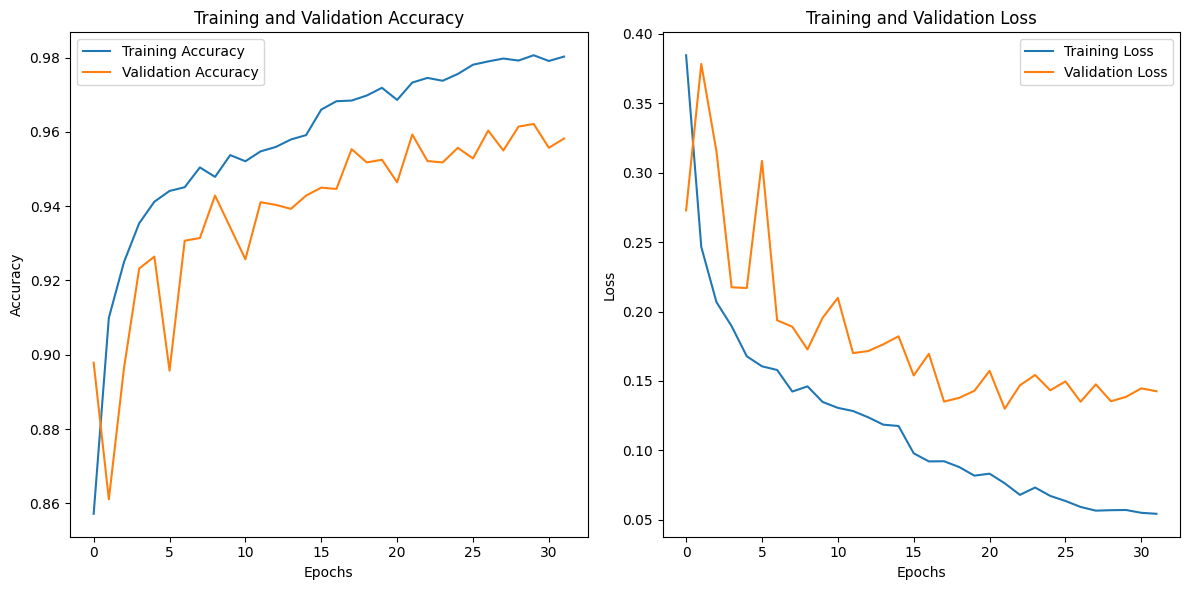

In [18]:
# Plot training accuracy & loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
